# Schema Setup / Dataset Loading

In [1]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType

feats = []
f = open('features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)
print(schema)

#df = spark.read.format('csv').option('sep', '\t').schema(schema).load('/some/where/out/there/NAM_2015_S/*')
df = spark.read.format('csv').option('sep', '\t').schema(schema).load('/Users/matthew/nbs/nam_mini.tdv')

StructType(List(StructField(Timestamp,LongType,true),StructField(Geohash,StringType,true),StructField(geopotential_height_lltw,FloatType,true),StructField(water_equiv_of_accum_snow_depth_surface,FloatType,true),StructField(drag_coefficient_surface,FloatType,true),StructField(sensible_heat_net_flux_surface,FloatType,true),StructField(categorical_ice_pellets_yes1_no0_surface,FloatType,true),StructField(visibility_surface,FloatType,true),StructField(number_of_soil_layers_in_root_zone_surface,FloatType,true),StructField(categorical_freezing_rain_yes1_no0_surface,FloatType,true),StructField(pressure_reduced_to_msl_msl,FloatType,true),StructField(upward_short_wave_rad_flux_surface,FloatType,true),StructField(relative_humidity_zerodegc_isotherm,FloatType,true),StructField(categorical_snow_yes1_no0_surface,FloatType,true),StructField(u-component_of_wind_tropopause,FloatType,true),StructField(surface_wind_gust_surface,FloatType,true),StructField(total_cloud_cover_entire_atmosphere,FloatType,tru

# Preparing the Data

Spark ML models need two columns: features (predictors), and labels (the target feature being predicted). We need to adjust our dataframe accordingly.

In [2]:
from pyspark.ml.feature import VectorAssembler

def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")


prepped = prepare_data(df,
    ["total_cloud_cover_entire_atmosphere", 
         "relative_humidity_zerodegc_isotherm", 
         "snow_cover_surface", 
         "visibility_surface"],
    "temperature_surface")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])


+--------------------+---------+
|            features|    label|
+--------------------+---------+
|[100.0,1.0,0.0,24...|286.74802|
|[0.0,2.0,0.0,2422...|297.49802|
|[100.0,95.0,0.0,2...|286.37302|
|[0.0,4.0,0.0,2422...|296.74802|
|[0.0,13.0,0.0,242...|291.24802|
|[100.0,95.0,100.0...|271.12302|
|[78.0,2.0,0.0,242...|296.87302|
|[0.0,6.0,0.0,2422...|284.24802|
|[100.0,81.0,0.0,2...|280.49802|
|[70.0,49.0,100.0,...|279.12302|
|[100.0,11.0,0.0,2...|289.24802|
|[100.0,90.0,0.0,8...|288.87302|
|[52.0,73.0,100.0,...|251.12302|
|[100.0,98.0,0.0,7...|290.49802|
|[6.0,50.0,0.0,228...|293.62302|
|[82.0,82.0,0.0,24...|293.24802|
|[8.0,35.0,0.0,242...|298.99802|
|[100.0,90.0,100.0...|272.99802|
|[100.0,34.0,100.0...|272.74802|
|[0.0,82.0,0.0,242...|278.62302|
+--------------------+---------+
only showing top 20 rows



In [3]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=5, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 6.89211


When I run this on the mini dataset, I get an RMSE of 6.9 degrees K. That's quite a bit of error, but let's see how well we're fitting our data visually...

# Lag Plot

Note: you may need to sample from the predictions if your dataset is too large.

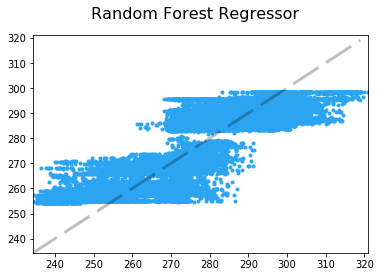

In [4]:
import matplotlib.pyplot as plt

p_df = predictions.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()

Hmm, not so good... Perhaps we need to play with model parameters, or choose another model!